### 1) Load necessary Python packages

In [17]:
import os
import sys
import dill

# Add the local src directory to the path
sys.path.append('./src/')

# Load the GBA_model class
from GBA_model import *

### 2) Define a function to load a model from a binary backup
See the script `csv_to_binary.py`.

In [18]:
### Load the model from a binary file ###
def load_model( model_name ):
    filename = "./binary_models/"+model_name+".gba"
    assert os.path.isfile(filename), "ERROR: model not found."
    ifile = open(filename, "rb")
    model = dill.load(ifile)
    ifile.close()
    return model

### 3) Load the model "EC12b" (a very abstract model of <em>E. coli</em>)

In [19]:
# I previously saved the model as a binary file with the script `csv_to_binary.py`
model = load_model("A")

### 4) Define the condition
The condition defines the environmental state of the cell (the composition of the medium). External concentrations are stored in the vector $x$.
Conditions are listed for the EC12b model in `./csv_models/EC12b/conditions.csv`.
We will use the condition 1.

In [20]:
model.set_condition("1")

In [21]:
model.solve_local_linear_problem()

### 6) Calculate all model variables

In [22]:
model.calculate()

In [23]:
import matplotlib.pyplot as plt
def plotTrajectory(timestamps, muRates):
  # Daten für die Zeitachse
  t = timestamps  # 100 Zeitpunkte von 0 bis 10

  # Daten für die Y-Achse (Beispiel: Sinusfunktion)
  mu = muRates

  # Erstellung des Plots
  plt.figure(figsize=(8, 6))  # Größe des Diagramms festlegen
  plt.plot(t, mu, label='mu(t)')  # Plot der Daten
  plt.xlabel('Time')  # Beschriftung der X-Achse
  plt.ylabel('mu')    # Beschriftung der Y-Achse
  plt.title('Plot of mu against Time')  # Titel des Diagramms
  plt.grid(True)      # Gitterlinien aktivieren
  plt.legend()        # Legende hinzufügen
  plt.show()          # Diagramm anzeigen
  print("max μ rate :")
  print(np.max(mu))
  return 

first next_f: 
[0.95]
first GCC_f: 
[  0.         -10.82954389]
[2.67616851]
[2.67616851 2.67851835]
[2.67616851 2.67851835 2.68000493]
[2.67616851 2.67851835 2.68000493 2.68097611]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718 ]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402 2.68273312]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402 2.68273312 2.68283859]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402 2.68273312 2.68283859 2.6829136 ]
[2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402 2.68273312 2.68283859 2.6829136  2.6829672 ]
[2.67616851 2.67851835 2.68000493 2.68097611 2.6

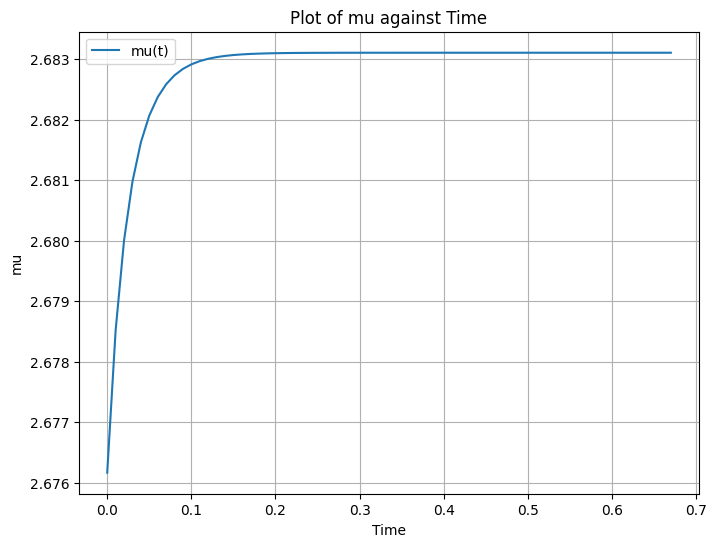

max μ rate :
2.683105890448202
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67] [2.67616851 2.67851835 2.68000493 2.68097611 2.68162545 2.68206722
 2.6823718  2.68258402 2.68273312 2.68283859 2.6829136  2.6829672
 2.68300563 2.68303328 2.68305323 2.68306764 2.68307808 2.68308565
 2.68309115 2.68309515 2.68309806 2.68310017 2.68310172 2.68310284
 2.68310367 2.68310427 2.6831047  2.68310502 2.68310526 2.68310543
 2.68310555 2.68310564 2.68310571 2.68310576 2.68310579 2.68310582
 2.68310584 2.68310585 2.68310586 2.68310587 2.68310588 2.68310588
 2.68310588 2.68310588 2.68310589 2.68310589 2.68310589 2.68310589
 2.68310589 2.68310589 2.68310589 2.68310589 2.68310589 2.68310589
 2.68310589 2.6831058

In [24]:
def trajectory(model,max_time=1000,first_dt = 0.01,dt_changeRate=0.1):
  threshold = 1e-5                   # for gradient "=" 0
  dt = first_dt
  t = 0                              # time
  consistent_f = np.copy(model.f_trunc) # safes consistent_f
  next_f = np.copy(model.f_trunc)     # the f_trunc, that we are going to change
  #allGCC_F = [model.GCC_f[1:]]       # to collect all previous GCC_f (just for checking the change of GCC_f)
  print("first next_f: ")
  print(next_f)
  print("first GCC_f: ")
  print(model.GCC_f)
  y_muRates = []                      #save muRates for plotting
  timestamps = []                     #save timeStamps for plotting
  while (t < max_time):                                                                 # end loop if time is up

    if( ( np.abs(model.GCC_f) <= threshold ).all() and model.consistent):               #(maybe use mu and look if it doesnt change for the next x steps , stop)
      print("absolute of GCC_F is less then threshold in GCC_F :", model.GCC_f)
      break

    #if np.any(next_f < 0):                                                            #negative value correction
    #  print("next_f before neg.correction:", next_f)
    #  next_f[next_f < 0] = 1e-10
    #  print("next_f after neg.correction:", next_f)

    #print("current gradient :", model.GCC_f)
    

    next_f = np.add(next_f, model.GCC_f[1:] * dt)                                      # add without first index of GCC_f

    #print(f"np.add({next_f}, {model.GCC_f[1:]} * {dt})")                                  # shows the term sum of next_f and GCC_f *dt

    model.set_f(next_f)
    model.calculate()
    #print("current growthrate",model.mu)
    #print("model is Consistent:" ,model.consistent)                                                          #calculate everything
 
    #allGCC_F = np.vstack((allGCC_F,model.GCC_f[1:]))                            # collects all previous GCC_f (just for checking the change of GCC_f)
    model.check_model_consistency()                                               #check consistency

    if (model.consistent):
      timestamps = np.append(timestamps,t)
      y_muRates = np.append(y_muRates,model.mu)
      print(y_muRates)
      t = t + dt                                                                  # calc. new t
      consistent_f = next_f                                                       # saves new f as the consistent f

    else:
      next_f = consistent_f                                                       #resets next_f to last consistent_f
      model.set_f(consistent_f)

      if (dt > 1e-100):                                                           # make sure dt is not too small
       dt = dt * dt_changeRate
    
       t = t + dt                                                                 # calc. new t
      else:
        break
      
  plotTrajectory(timestamps, y_muRates)
  print(timestamps, y_muRates, model.consistent)
  #print('Last GCC_f')
  #print(model.GCC_f)
  #print(allGCC_F)
  
  return 

trajectory(model, max_time=200, first_dt = 0.01, dt_changeRate=0.1)

